# Analysis of 10k station repacking instances

This notebook contains initial analyses to assess whether the computational results seem correct. For example, there should be a relationship between size and runtime.

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rc('text', usetex=True)
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
mpl.rcParams.update({'font.size': 13})

In [3]:
def listify_regex(string_of_ids):
    """Make a string of IDs to a list."""
    return re.sub("[^\w]", " ",  string_of_ids).split()

def dictify_regex_and_prune(string_of_assignments, prune=True):
    temp_list = re.sub("[^\w]", " ",  string_of_assignments).split()
    temp_dict = dict(zip(temp_list[::2], temp_list[1::2]))
    if prune:
        assignment = {k: v for k, v in temp_dict.items() if int(v) >= 14 and int(v) <= 36}
        return assignment
    else:
        return temp_dict

def get_assignment_dict(string_assignment, prune=True):
    assignment = string_assignment[1:-1]
    assignment = assignment.split(",")
    stations = [stationChannel.split(":")[0][1:-1] for stationChannel in assignment]
    channels = [stationChannel.split(":")[1] for stationChannel in assignment]
    assignment = dict(zip(stations, channels))
    if prune:
        assignment = {k: v for k,v in assignment.items() if int(v) >= 14 and int(v) <= 36}
    return assignment

In [405]:
current_palette = sns.color_palette("colorblind", 10)

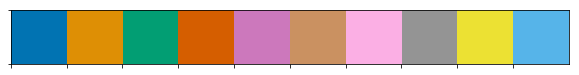

In [406]:
sns.palplot(current_palette)

In [407]:
triple_palette = [current_palette[i] for i in [0,4,7]]

In [7]:
#Set globals
pathToResults = "/Users/haakonhr/station-repacking/data/raw/FCCdata.csv"
pathToProperties = "/Users/haakonhr/station-repacking/data/processed/results.csv"
path_to_instances = "/Users/haakonhr/station-repacking/data/processed/extended_instance_information.csv"
threshold = 0.982

### Read data

In [8]:
# read instances
instances = pd.read_csv(path_to_instances)
instances.loc[:, "stations"] = instances.loc[:, "stations"].apply(listify_regex)
instances.loc[:, "assignment"] = instances.loc[:, "assignment"].apply(dictify_regex_and_prune, args=(False,))
instances = instances.set_index("id", drop=True)
instances.head()

stations  \
id                                                             
41-100899  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   
41-101096  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   
41-101114  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   
41-101373  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   
41-102360  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   

                                                  assignment  new_station  \
id                                                                          
41-100899  {'49157': '19', '4108': '28', '167948': '16', ...        72062   
41-101096  {'49157': '19', '4108': '28', '167948': '16', ...        67784   
41-101114  {'49157': '19', '4108': '28', '167948': '16', ...        12523   
41-101373  {'49157': '19', '4108': '28', '167948': '16', ...        41671   
41-102360  {'49157': '19', '4108': '28', '167948': '16', ...        41671   

           domain_size_new_station  
id                                  
41-100899                       18  
41-101096                       23  
41-101114                        5  
41-101373                       20  
41-102360                       20

In [9]:
instances.rename({"stations": "set_of_stations"}, inplace=True, axis=1)

In [10]:
instances.head()

set_of_stations  \
id                                                             
41-100899  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   
41-101096  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   
41-101114  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   
41-101373  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   
41-102360  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   

                                                  assignment  new_station  \
id                                                                          
41-100899  {'49157': '19', '4108': '28', '167948': '16', ...        72062   
41-101096  {'49157': '19', '4108': '28', '167948': '16', ...        67784   
41-101114  {'49157': '19', '4108': '28', '167948': '16', ...        12523   
41-101373  {'49157': '19', '4108': '28', '167948': '16', ...        41671   
41-102360  {'49157': '19', '4108': '28', '167948': '16', ...        41671   

           domain_size_new_station  
id                                  
41-100899                       18  
41-101096                       23  
41-101114                        5  
41-101373                       20  
41-102360                       20

In [11]:
# Read data
fcc = pd.read_csv(pathToResults, index_col=["id"])
fcc.head()

stations  channels  variables  clauses result  runtime
id                                                               
41-100899      1050        23      22763   449651    SAT    0.134
41-101096      1059        23      22968   457655    SAT    0.144
41-101114      1059        23      22950   456366    SAT    0.087
41-101373      1059        23      22965   457161    SAT    0.195
41-102360      1059        23      22965   457161    SAT    0.094

In [12]:
props = pd.read_csv(pathToProperties, index_col = ["id"])
props.drop(["domainNew", "clqNew"], inplace=True, axis=1)
props.head()

szComp  ratioComp  avgDomainComp  szKernel  ratioKrnl  \
id                                                                 
41-100899     632  25.980037      22.113924         0   0.000000   
41-101096     640  26.025026      22.132812       113  36.428882   
41-101114     640  26.007422      22.104688       116  36.283479   
41-101373     640  26.027080      22.128125       159  39.565537   
41-102360     640  26.027080      22.128125       159  39.565537   

           avgDomainKrnl    V     avgDeg  maxDeg  medDeg   density  diameter  \
id                                                                             
41-100899       0.000000    0   0.000000       0     0.0  0.000000         0   
41-101096      22.398230   83  24.987952      51    24.0  0.304731         4   
41-101114      21.758621    4   3.000000       3     3.0  1.000000         1   
41-101373      22.264151  159  22.465409      50    21.0  0.142186         7   
41-102360      22.264151  159  22.465409      50    21.0  0.142186         7   

            lambda2    lambdaN  nghbNew  
id                                       
41-100899  0.000000  18.000000        0  
41-101096  1.885134  52.134897       34  
41-101114  4.000000   4.000000        6  
41-101373  0.383985  51.168918       22  
41-102360  0.383985  51.168918       22

In [13]:
df = instances.join([fcc, props])

In [14]:
len(df.iloc[0, 0])

1050

In [15]:
df.head()

set_of_stations  \
id                                                             
41-100899  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   
41-101096  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   
41-101114  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   
41-101373  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   
41-102360  [126, 131, 146, 147, 306, 307, 308, 411, 412, ...   

                                                  assignment  new_station  \
id                                                                          
41-100899  {'49157': '19', '4108': '28', '167948': '16', ...        72062   
41-101096  {'49157': '19', '4108': '28', '167948': '16', ...        67784   
41-101114  {'49157': '19', '4108': '28', '167948': '16', ...        12523   
41-101373  {'49157': '19', '4108': '28', '167948': '16', ...        41671   
41-102360  {'49157': '19', '4108': '28', '167948': '16', ...        41671   

           domain_size_new_station  stations  channels  variables  clauses  \
id                                                                           
41-100899                       18      1050        23      22763   449651   
41-101096                       23      1059        23      22968   457655   
41-101114                        5      1059        23      22950   456366   
41-101373                       20      1059        23      22965   457161   
41-102360                       20      1059        23      22965   457161   

          result  runtime   ...     avgDomainKrnl    V     avgDeg  maxDeg  \
id                          ...                                             
41-100899    SAT    0.134   ...          0.000000    0   0.000000       0   
41-101096    SAT    0.144   ...         22.398230   83  24.987952      51   
41-101114    SAT    0.087   ...         21.758621    4   3.000000       3   
41-101373    SAT    0.195   ...         22.264151  159  22.465409      50   
41-102360    SAT    0.094   ...         22.264151  159  22.465409      50   

           medDeg   density  diameter   lambda2    lambdaN  nghbNew  
id                                                                   
41-100899     0.0  0.000000         0  0.000000  18.000000        0  
41-101096    24.0  0.304731         4  1.885134  52.134897       34  
41-101114     3.0  1.000000         1  4.000000   4.000000        6  
41-101373    21.0  0.142186         7  0.383985  51.168918       22  
41-102360    21.0  0.142186         7  0.383985  51.168918       22  

[5 rows x 25 columns]

### TODO: update clqNew

10/02: This will not be done.

Now only a good lower bound for the *clique coefficient* is missing to complete the data in df.

# Introduction 

This notebook analyzes the set of 10'000 non-trivial instances. The goal is to answer the following questions:
* Why are most instances quickly solved?
* What is the difference between the instances that are solved quickly and not?
* What is the difference between instances that times out versus ones that do not?
* Which stations occur again and again as the last added station?

# Methodology: Analysing the instances

What is a good measure of the difficulty of an instance? The obvious, post-solution is of course the runtime and the result as this is essentially the answer. If it could not be solved by a well-tuned portfolio of algorithms within the cutoff time or it took most of the time. There are other measures as well, such as the number of vertices, the number of vertices in the *relevant* connected component, the density and the size of the relevant component when unrestricted stations are removed. Any good measure should, for our purposes, correlate well with or predict the runtime.

There are two ways forward: typical machine learning approaches were we try to predict either the runtime or the result. The other is the classical statistics.

Our goal is inference. What are the underlying factors that makes some instances hard and others not? A secondary goal is hypothesis generation. Can we actually prove something?

# 1 Cleaning

First we remove all trivial instances from the dataframe. A trivial instance is one that purely consists of unconstrained stations.

In [16]:
df.columns

Index(['set_of_stations', 'assignment', 'new_station',
       'domain_size_new_station', 'stations', 'channels', 'variables',
       'clauses', 'result', 'runtime', 'szComp', 'ratioComp', 'avgDomainComp',
       'szKernel', 'ratioKrnl', 'avgDomainKrnl', 'V', 'avgDeg', 'maxDeg',
       'medDeg', 'density', 'diameter', 'lambda2', 'lambdaN', 'nghbNew'],
      dtype='object')

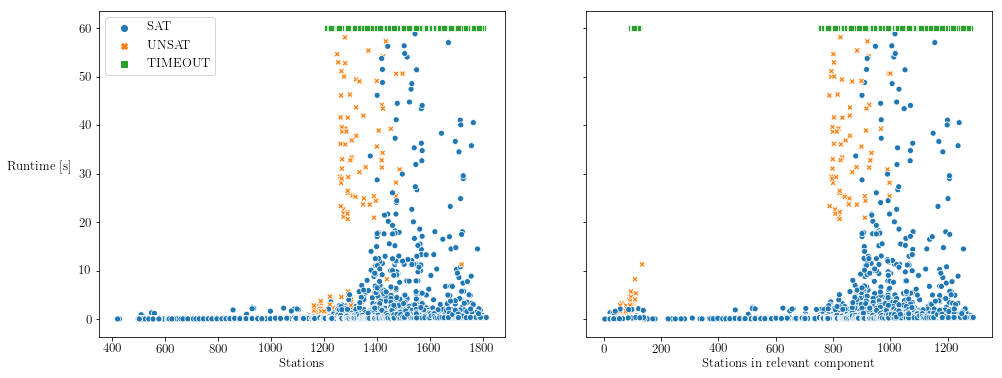

In [408]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.scatterplot(x="stations", y="runtime", data=df, hue="result",
                style="result", ax=axes[0],
               style_order=["SAT", "UNSAT", "TIMEOUT"])
sns.scatterplot(x="szComp", y="runtime", data=df, hue="result",
                style="result", ax=axes[1], legend=False,
               style_order=["SAT", "UNSAT", "TIMEOUT"])
axes[1].set(xlabel="Stations in relevant component")
axes[0].set(xlabel="Stations")
axes[0].set_ylabel("Runtime [s]", rotation=0, labelpad=40)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[1:], labels[1:])

In [409]:
fig.savefig("../reports/figures/runtime_and_size.pdf")

In [410]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.scatterplot(x="clauses", y="runtime", data=df, hue="result",
                style="result", ax=axes[0],
               style_order=["SAT", "UNSAT", "TIMEOUT"])
sns.scatterplot(x="variables", y="runtime", data=df, hue="result",
                style="result", ax=axes[1], legend=False,
               style_order=["SAT", "UNSAT", "TIMEOUT"])
axes[1].set(xlabel="Variables in SAT formulation")
axes[0].set(xlabel="Clauses in SAT formulation")
axes[0].set_ylabel("Runtime [s]", rotation=0, labelpad=40)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[1:], labels[1:])

In [411]:
fig.savefig("../reports/figures/runtimes_and_SAT_sizes.pdf")

We also know that several instances are solved by a local-search pre-solver on a restricted problem obtained by fixing the all stations outside of the neighborhood of some order. Similarly, a cache exists (but was it used?)

In [21]:
crit_1s_cutoff = df["runtime"] < 0.982

In [22]:
df.loc[crit_1s_cutoff, "result"].value_counts()

SAT    8753
Name: result, dtype: int64

In [23]:
df[df["runtime"] < 0.982]["nghbNew"].describe()

count    8753.000000
mean       29.659888
std        14.094040
min         0.000000
25%        22.000000
50%        31.000000
75%        39.000000
max        87.000000
Name: nghbNew, dtype: float64

In [24]:
df[df["runtime"] >= 0.982]["nghbNew"].describe()

count    1247.000000
mean       37.821973
std        12.996248
min         0.000000
25%        28.000000
50%        37.000000
75%        47.000000
max        88.000000
Name: nghbNew, dtype: float64

In [25]:
df_pruned = df.drop(df[crit_1s_cutoff].index)

In [26]:
len(df_pruned)

1247

In [27]:
#get instance-ids of pruned instances
df_pruned.reset_index(drop=False).to_csv("../data/interim/pruned_instances.csv", index=False)

# Kernelized instances

In [28]:
crit_SAT = df_pruned["result"] == "SAT"
crit_TIMEOUT = df_pruned["result"] == "TIMEOUT"
crit_UNSAT = df_pruned["result"] == "UNSAT"

In [385]:
len(df[df["szKernel"] == 0])

721

In [387]:
sns.distplot(df.loc[df["result"] == "SAT", "szKernel"])

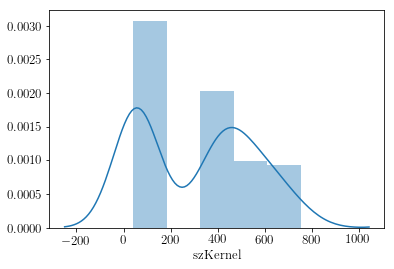

In [389]:
sns.distplot(df.loc[df["result"] == "UNSAT", "szKernel"])

In [388]:
sns.distplot(df.loc[df["result"] == "TIMEOUT", "szKernel"])

In [386]:
df.groupby("result")["szKernel"].describe()

count        mean         std   min    25%    50%    75%     max
result                                                                    
SAT      9482.0  414.544084  288.501156   0.0  115.0  427.0  627.0  1094.0
TIMEOUT   397.0  702.957179  267.286525  63.0  627.0  773.0  874.0  1089.0
UNSAT     121.0  307.462810  238.456496  40.0   57.0  373.0  481.0   752.0

In [ ]:
df[""]

In [29]:
df_pruned[crit_UNSAT]["runtime"].describe()

count    121.000000
mean      21.822074
std       18.890163
min        0.982000
25%        2.250000
50%       23.310000
75%       37.832000
max       58.153000
Name: runtime, dtype: float64

In [30]:
crit_unconstrained = df["szKernel"].le(df["domain_size_new_station"])
crit_unconstrained_pruned = df_pruned["szKernel"].eq(0)
crit_unconstrained_domain_pruned = df_pruned["szKernel"].le(df_pruned["domain_size_new_station"])

In [31]:
len(df.loc[crit_unconstrained, :])

807

In [32]:
len(df_pruned[crit_unconstrained_domain_pruned])

4

In [33]:
len(df_pruned[crit_unconstrained_pruned])

4

In [35]:
crit_unconstrained = df["szKernel"].eq(0)
len(df.loc[crit_unconstrained, :])

721

In [36]:
df[df["szKernel"] < df["domain_size_new_station"]].groupby("result")["runtime"].describe()

count     mean       std    min    25%     50%      75%    max
result                                                                
SAT     804.0  0.09694  0.118008  0.023  0.047  0.0715  0.11625  2.128

In [37]:
len(df[df["szKernel"] > df["nghbNew"]])

9129

In [38]:
len(df[df["szKernel"] == df["nghbNew"]])

764

In [39]:
len(df[df["szKernel"].ge(df["nghbNew"])])

9893

In [40]:
df[crit_unconstrained]["runtime"].describe()

count    721.000000
mean       0.093452
std        0.121727
min        0.023000
25%        0.045000
50%        0.069000
75%        0.108000
max        2.128000
Name: runtime, dtype: float64

There are 721 such instances that can be dropped, all of which are satisfiable with a mean runtime of 0.09s. 

This cleaning leaves 1243 instances.

In [41]:
df_pruned["result"].value_counts()

SAT        729
TIMEOUT    397
UNSAT      121
Name: result, dtype: int64

In [42]:
df_pruned.columns

Index(['set_of_stations', 'assignment', 'new_station',
       'domain_size_new_station', 'stations', 'channels', 'variables',
       'clauses', 'result', 'runtime', 'szComp', 'ratioComp', 'avgDomainComp',
       'szKernel', 'ratioKrnl', 'avgDomainKrnl', 'V', 'avgDeg', 'maxDeg',
       'medDeg', 'density', 'diameter', 'lambda2', 'lambdaN', 'nghbNew'],
      dtype='object')

In [43]:
df_pruned.groupby("result")["runtime"].describe()

count       mean        std     min     25%     50%     75%     max
result                                                                      
SAT      729.0   5.626894   9.765155   0.985   1.224   1.846   4.395  58.870
TIMEOUT  397.0  59.999992   0.000151  59.997  60.000  60.000  60.000  60.000
UNSAT    121.0  21.822074  18.890163   0.982   2.250  23.310  37.832  58.153

In [44]:
df_pruned["logRuntime"] = df["runtime"].apply(np.log)

In [45]:
df_pruned.head()

set_of_stations  \
id                                                             
41-111680  [126, 131, 146, 147, 257, 267, 306, 307, 308, ...   
41-112249  [126, 131, 146, 147, 257, 267, 306, 307, 308, ...   
41-114471  [126, 131, 146, 147, 257, 267, 306, 307, 308, ...   
41-114475  [126, 131, 146, 147, 257, 267, 306, 307, 308, ...   
41-114504  [126, 131, 146, 147, 257, 267, 306, 307, 308, ...   

                                                  assignment  new_station  \
id                                                                          
41-111680  {'49157': '19', '4108': '28', '167948': '16', ...        38430   
41-112249  {'49157': '19', '4108': '28', '167948': '16', ...        36989   
41-114471  {'49157': '28', '4108': '28', '167948': '16', ...        47929   
41-114475  {'49157': '28', '4108': '28', '167948': '16', ...        28480   
41-114504  {'49157': '28', '4108': '28', '167948': '16', ...       191340   

           domain_size_new_station  stations  channels  variables  clauses  \
id                                                                           
41-111680                        8      1222        23      26380   581814   
41-112249                       15      1225        23      26432   584409   
41-114471                       16      1258        23      27101   614516   
41-114475                       15      1258        23      27100   614322   
41-114504                       15      1258        23      27100   614213   

            result  runtime     ...        V     avgDeg  maxDeg  medDeg  \
id                              ...                                       
41-111680    UNSAT    4.636     ...       46  19.521739      32    19.0   
41-112249      SAT    3.556     ...      398  25.311558      67    24.0   
41-114471  TIMEOUT   60.000     ...      441  26.884354      69    26.0   
41-114475  TIMEOUT   60.000     ...      440  26.850000      68    26.0   
41-114504  TIMEOUT   60.000     ...      440  26.813636      68    26.0   

            density  diameter   lambda2    lambdaN  nghbNew  logRuntime  
id                                                                       
41-111680  0.433816         3  1.700059  33.479971       19    1.533852  
41-112249  0.063757        12  0.214683  68.199248       28    1.268636  
41-114471  0.061101        12  0.269974  70.223061       41    4.094345  
41-114475  0.061162        12  0.270176  69.223464       28    4.094345  
41-114504  0.061079        12  0.269982  69.223460       19    4.094345  

[5 rows x 26 columns]

**TODO**: Write about the data collection process! Needs to be in the thesis properly written.

# 1.9 Diameters and paths

In [412]:
df_pruned.groupby(["result", "diameter"])["runtime"].describe()

count       mean        std     min       25%      50%  \
result  diameter                                                           
SAT     0           4.0   1.409250   0.493059   1.016   1.15100   1.2465   
        1           2.0   1.186000   0.123037   1.099   1.14250   1.1860   
        2           5.0   1.557800   0.461903   1.059   1.26600   1.5250   
        3           2.0   1.551500   0.490025   1.205   1.37825   1.5515   
        4          11.0   2.039818   0.210196   1.634   1.95600   2.0870   
        6           1.0   1.813000        NaN   1.813   1.81300   1.8130   
        7          11.0   1.858364   0.511536   1.043   1.45600   2.0870   
        8          17.0   2.304882   0.496111   1.231   2.04300   2.2460   
        9           4.0   1.817500   0.969766   1.067   1.19975   1.4990   
        10          9.0   1.861889   1.527486   1.073   1.24300   1.3060   
        11         12.0  11.668500  14.655554   1.041   2.05000   4.5825   
        12        352.0   5.688912   9.579217   0.986   1.22625   1.8630   
        13        299.0   6.129375  10.585637   0.985   1.17100   1.7240   
TIMEOUT 4          21.0  60.000000   0.000000  60.000  60.00000  60.0000   
        6           4.0  60.000000   0.000000  60.000  60.00000  60.0000   
        7          23.0  60.000000   0.000000  60.000  60.00000  60.0000   
        8          13.0  60.000000   0.000000  60.000  60.00000  60.0000   
        9           1.0  60.000000        NaN  60.000  60.00000  60.0000   
        10          2.0  60.000000   0.000000  60.000  60.00000  60.0000   
        11          5.0  60.000000   0.000000  60.000  60.00000  60.0000   
        12        193.0  60.000000   0.000000  60.000  60.00000  60.0000   
        13        135.0  59.999978   0.000258  59.997  60.00000  60.0000   
UNSAT   3          13.0   2.479154   1.533649   0.982   1.50300   1.9790   
        4          30.0   2.327167   1.316586   1.278   1.68350   1.9445   
        6           2.0   7.844500   4.872673   4.399   6.12175   7.8445   
        7          13.0  19.070462  21.360598   1.647   3.00900   4.0480   
        8           9.0  36.131222  10.988762  22.640  28.10400  36.1840   
        9           2.0  21.481500   0.505581  21.124  21.30275  21.4815   
        10          3.0  54.368333   1.249766  52.991  53.83750  54.6840   
        11          6.0  35.251500   4.252720  29.008  32.84350  35.8340   
        12         29.0  37.075655  11.192022  20.654  26.47900  35.6110   
        13         14.0  32.633571  10.504463  20.936  25.02275  29.2400   

                       75%     max  
result  diameter                    
SAT     0          1.50475   2.128  
        1          1.22950   1.273  
        2          1.67000   2.269  
        3          1.72475   1.898  
        4          2.11800   2.454  
        6          1.81300   1.813  
        7          2.18200   2.602  
        8          2.60300   3.414  
        9          2.11675   3.205  
        10         1.63000   5.892  
        11        17.18425  46.183  
        12         5.06150  56.408  
        13         4.93450  58.870  
TIMEOUT 4         60.00000  60.000  
        6         60.00000  60.000  
        7         60.00000  60.000  
        8         60.00000  60.000  
        9         60.00000  60.000  
        10        60.00000  60.000  
        11        60.00000  60.000  
        12        60.00000  60.000  
        13        60.00000  60.000  
UNSAT   3          2.87400   5.689  
        4          2.60725   8.238  
        6          9.56725  11.290  
        7         39.63300  51.156  
        8         41.99400  52.819  
        9         21.66025  21.839  
        10        55.05700  55.430  
        11        38.69550  39.337  
        12        46.33200  58.153  
        13        39.17875  57.324

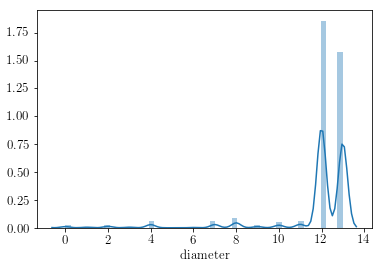

In [413]:
sns.distplot(df_pruned.loc[df_pruned["result"] == "SAT", "diameter"])

In [414]:
sns.distplot(df_pruned.loc[df_pruned["result"] == "UNSAT", "diameter"])

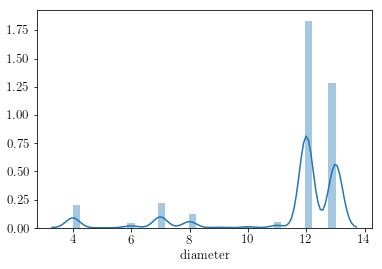

In [415]:
sns.distplot(df_pruned.loc[df_pruned["result"] == "TIMEOUT", "diameter"])

In [417]:
sns.scatterplot(data=df_pruned, x="diameter", y="runtime", hue="result",style_order=["SAT",
                                                                                    "UNSAT",
                                                                                    "TIMEOUT"])

In [431]:
diameter = dict(df_pruned["diameter"].value_counts())

In [442]:
sorted_diameter = {k: diameter.get(k, 0) for k in range(1, max(list(diameter.keys())) + 1)}

In [443]:
sorted_diameter

{1: 2,
 2: 5,
 3: 15,
 4: 62,
 5: 0,
 6: 7,
 7: 47,
 8: 39,
 9: 7,
 10: 14,
 11: 23,
 12: 574,
 13: 448}

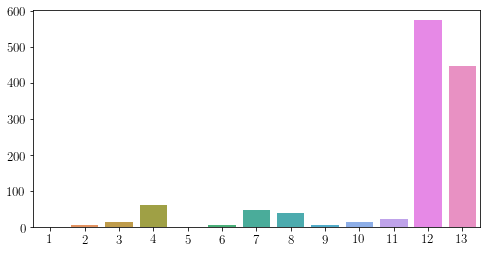

In [444]:
dim, ax = plt.subplots(figsize=(8,4))
sns.barplot(x=list(sorted_diameter.keys()),
            y=list(sorted_diameter.values()),
            ax=ax)

In [445]:
dim.savefig("../reports/figures/diameter_barplot.pdf")

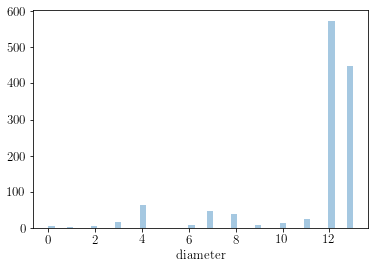

In [428]:
sns.distplot(df_pruned["diameter"], kde=False)

# 2 Exploring the instances

The first scatter matrix takes several parameters and plots them w.r.t runtime, colored by result.

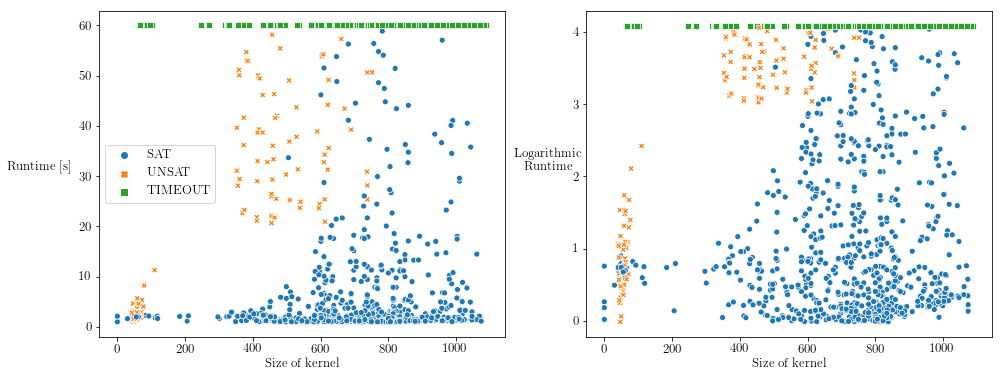

In [420]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(data=df_pruned, x="szKernel", y="runtime",
                          hue="result", style="result", ax=axes[0],
               style_order=["SAT", "UNSAT", "TIMEOUT"],
               hue_order=["SAT", "UNSAT", "TIMEOUT"])

sns.scatterplot(data=df_pruned, x="szKernel", y="logRuntime",
                          hue="result", style="result", ax=axes[1], legend=False,
               style_order=["SAT", "UNSAT", "TIMEOUT"],
               hue_order=["SAT", "UNSAT", "TIMEOUT"])
axes[0].set_ylabel("Runtime [s]", rotation=0, labelpad=40)
axes[1].set_ylabel("Logarithmic \n Runtime", rotation = 0, labelpad=25)
axes[0].set_xlabel("Size of kernel")
axes[1].set_xlabel("Size of kernel")
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[1:], labels[1:])

In [421]:
fig.savefig("../reports/figures/runtime_and_kernel.pdf")

The scatter matrix considers the different size parameters and degree parameters, which implicitly incorporates density. The distribution is fairly similar and there does not seem to be a clear relationship between the size and the runtime, although for the satisfiable instances only the large ones take more time. One might gauge an exponential relationship and interestingly, for the unsatisfiable instances, the instances seem to end up in two clusters, which is more obvious for the logarithmic plot. 

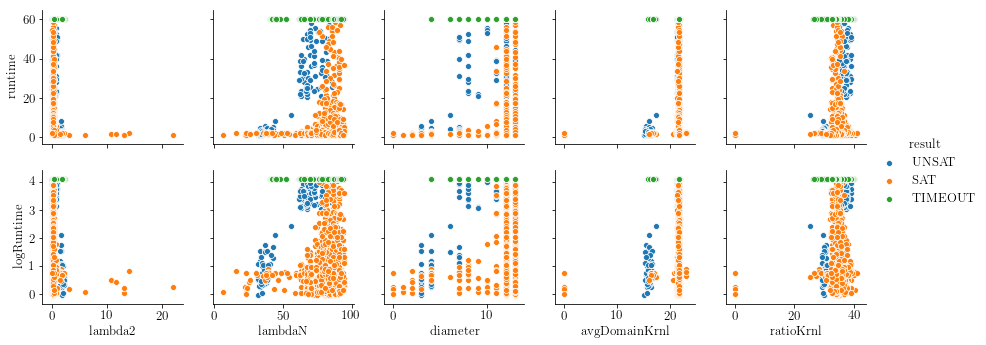

In [393]:
sns.pairplot(df_pruned, x_vars=["lambda2", "lambdaN", "diameter", "avgDomainKrnl", "ratioKrnl"],
             y_vars=["runtime", "logRuntime"], hue="result")

The plot above considers the remaining parameters w.r.t runtime. Again clusters are seen visually for the unsatisfiable instances. Interestingly, many of the unsatisfiable instances have smaller average domains, which makes sense as this means that it is less likely that a feasible assignment exists. Let's zoom in a bit on that one.

In [ ]:
df_pruned.columns

Text(0,0.5,'Runtime [s]')

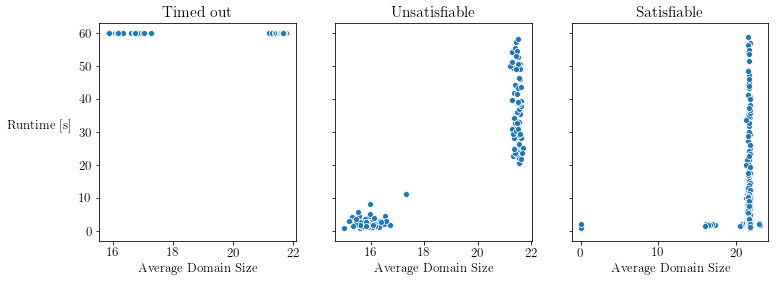

In [402]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12,4))
sns.scatterplot(data=df_pruned[crit_TIMEOUT], x="avgDomainKrnl", y="runtime", ax=ax1)
ax1.set_title("Timed out")
ax1.set_xlabel("Average Domain Size")
sns.scatterplot(data=df_pruned[crit_UNSAT], x="avgDomainKrnl", y="runtime", ax=ax2)
ax2.set_title("Unsatisfiable")
ax2.set_xlabel("Average Domain Size")
sns.scatterplot(data=df_pruned[crit_SAT], x="avgDomainKrnl", y="runtime", ax=ax3)
ax3.set_title("Satisfiable")
ax3.set_xlabel("Average Domain Size")
ax1.set_ylabel("Runtime [s]", rotation=0, labelpad=40)

In [399]:
f.savefig("../reports/figures/runtime_and_domain_size.pdf")

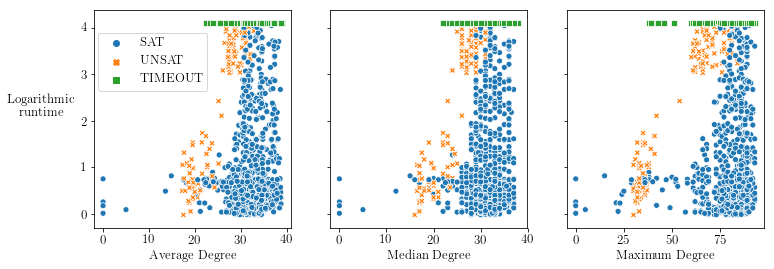

In [422]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12,4))
sns.scatterplot(data=df_pruned, x="avgDeg", y="logRuntime", ax=ax1, hue="result", style="result",
               style_order=["SAT", "UNSAT", "TIMEOUT"],
               hue_order=["SAT", "UNSAT", "TIMEOUT"])
ax1.set_xlabel("Average Degree")
sns.scatterplot(data=df_pruned, x="medDeg", y="logRuntime", ax=ax2, hue="result", style="result",
               legend=False, style_order=["SAT", "UNSAT", "TIMEOUT"],
               hue_order=["SAT", "UNSAT", "TIMEOUT"])
ax2.set_xlabel("Median Degree")
sns.scatterplot(data=df_pruned, x="maxDeg", y="logRuntime", ax=ax3, hue="result", style="result",
               legend=False, style_order=["SAT", "UNSAT", "TIMEOUT"],
               hue_order=["SAT", "UNSAT", "TIMEOUT"])
ax3.set_xlabel("Maximum Degree")
ax1.set_ylabel("Logarithmic \n runtime", rotation=0, labelpad=40)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[1:], labels[1:], loc=(0.02, 0.63))

In [425]:
f.savefig("../reports/figures/runtime_and_degree.pdf")

We can visually confirm that the avgDomainKrnl clusters the unsatisfiable and timed out instances into two.

In [424]:
df_pruned["new_station"].value_counts()[:10]

53716    15
1222     13
50141    11
69273    10
33081    10
66219    10
61009    10
69300    10
23942     9
69149     9
Name: new_station, dtype: int64

In [ ]:
len(df_pruned["new_station"].unique())

Interestingly, there are only 390 stations that are the new station for the pruned instances compared with 692 in the original instances.

Let us look closer into the properties of the new stations and whether they have any importance.

In [ ]:
df_pruned.rename({"domain_size_new_station": "domainSzNewStation", "new_station":"newStation"}, inplace=True, axis=1)

In [ ]:
df_pruned.columns

In [ ]:
sns.pairplot(df_pruned, vars=["avgDomainKrnl", "domainSzNewStation", "nghbNew",
                              "logRuntime", "runtime"], hue="result")

Not much to infer from the above plots other than that unsatisfiability sometimes happens due to small domains of the new station, which makes sense.

Now let's look closer at the fast ones and try to determine why they are so quick and if we can characterize local neighborhood solvability.

In [ ]:
df_pruned_fast.rename({"domain_size_new_station":"domainSzNewStation", "new_station":"newStation"}, inplace=True, axis=1)

In [ ]:
df_pruned_fast.columns

In [ ]:
sns.pairplot(df_pruned_fast, vars=["nghbNew")

# Analysis of trivial instance

How can we classify simple instances? The runtime is the easy answer. If an instance is solved within a second or so it is likely to be solved by the pre-solver, which uses a local neighborhood search.

In [ ]:
crit_small_kernel = props.loc[:, "szKernel"].le(100)

#### By density

Is an instance rural or urban? Sparse or dense?

In [ ]:
df.columns

In [ ]:
crit_rural = df["medDeg"].le(15)
crit_urban = df["medDeg"].ge(33)

In [ ]:
df.loc[crit_rural, "result"].value_counts()

In [ ]:
df.loc[crit_urban, "result"].value_counts()

In [ ]:
crit_rural = props.loc[:, "maxDegree"].le(20)
crit_urban = props.loc[:, "density"].ge(0.9)
crit_suburbia = (crit_rural.eq(False)) & (crit_urban.eq(False))

In [ ]:
fcc[crit_rural]["result"].value_counts()

In [ ]:
fcc[crit_urban]["result"].value_counts()

#### Trivially unsatisfiable instances

In [ ]:
# Check cliques larger than |D(s)|
largeClqCrit = props["clqNew"] > props["domainNew"]
fcc[largeClqCrit].groupby("result").count()

What the hell? How can these be **satisfiable**? See comment above. However, it is good to see that most of the unsatisfiabile and timed out instances also belong here. Of the 131 UNSAT instances 112 are there and of the 397 TIMEOUT instances 264 are there.

In [446]:
df_pruned.groupby("result")["szKernel"].describe()

count        mean         std   min    25%    50%    75%     max
result                                                                   
SAT      729.0  729.574760  200.092816   0.0  626.0  767.0  847.0  1074.0
TIMEOUT  397.0  702.957179  267.286525  63.0  627.0  773.0  874.0  1089.0
UNSAT    121.0  307.462810  238.456496  40.0   57.0  373.0  481.0   752.0

In [450]:
df_test = df.copy()

In [455]:
df_pruned.loc[:, "kernelization_rate"] = (df_pruned["szComp"] - df_pruned["szKernel"]) / df_pruned["szComp"]

In [460]:
df_pruned.groupby("result")["kernelization_rate"].describe().to_csv("../reports/kernelization_rate.csv")

In [459]:
df_pruned.groupby("result")["szKernel"].describe().to_csv("../reports/test.csv")

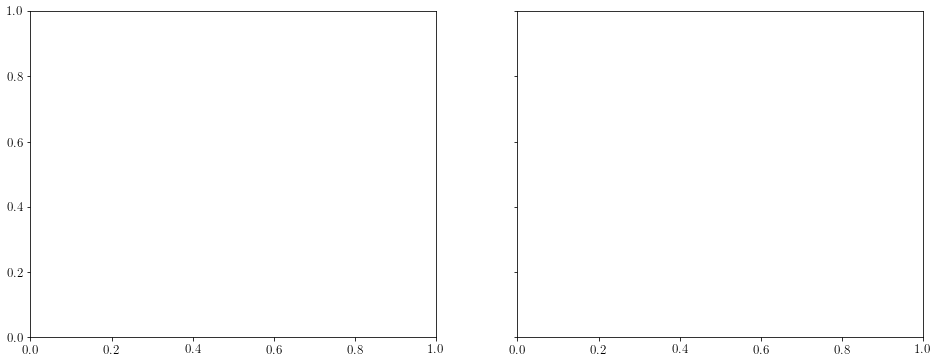

In [494]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

In [495]:
sns.distplot(df_pruned.loc[df["result"] == "UNSAT", "szKernel"], bins=20,
             kde=False, ax=axes[0], color=current_palette[0],
            label="Unsatisfiable")
sns.distplot(df_pruned.loc[df["result"] == "TIMEOUT", "szKernel"], bins=20,
             kde=False, ax=axes[1], color=current_palette[2],
            label="Timed out")
axes[0].set_xlabel("Size of kernel")
axes[1].set_xlabel("Size of kernel")
axes[0].set_ylabel("Number of \n instances", rotation=0, labelpad=30)
axes[0].legend()
axes[1].legend()

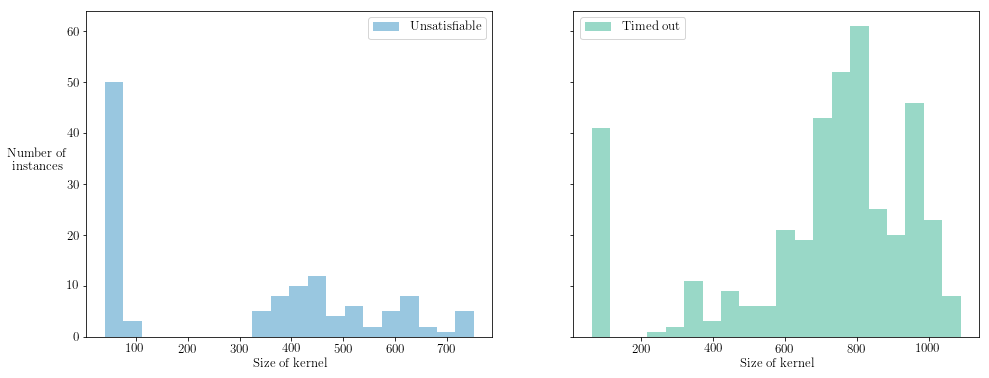

In [496]:
fig

In [497]:
fig.savefig("../reports/figures/kernel_distribution_grouped.pdf")

In [457]:
df_pruned.loc[df_pruned["szKernel"].eq(0), "kernelization_rate"]

id
41-27283    1.0
46-28750    1.0
56-84442    1.0
60-88509    1.0
Name: kernelization_rate, dtype: float64

## Further Analysis

The first table describes the cluster of unsatisfiable instances in the lower left corner, while the second table above describes the rest of the unsatisfiable instances. It can be seen that the distribution of average degree of the relevant interference graph component is strictly separated, in the sense that the minimum average degree of unsatisfiable instances not in the cluster is strictly higher than the maxim

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = unsatFastC.values
y = fcc[fcc.index.isin(idsUnsatC)]["runtime"].values
X = StandardScaler().fit_transform(X)

pca = PCA(.95)
pca.fit(X)

print(pca.explained_variance_ratio_)
for pc in pca.explained_variance_ratio_:
    print(pc)
for sv in pca.singular_values_:
    print(sv)

### Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

We train two models. We first assume that all the timed out instances are in fact unsatisfiable instances leaving us with two classes, satisfiable and unsatisfiable. In the second model we try to separate the unsatisfiable instances that timed out from the ones that did not.

In [47]:
df.columns

Index(['set_of_stations', 'assignment', 'new_station',
       'domain_size_new_station', 'stations', 'channels', 'variables',
       'clauses', 'result', 'runtime', 'szComp', 'ratioComp', 'avgDomainComp',
       'szKernel', 'ratioKrnl', 'avgDomainKrnl', 'V', 'avgDeg', 'maxDeg',
       'medDeg', 'density', 'diameter', 'lambda2', 'lambdaN', 'nghbNew'],
      dtype='object')

In [48]:
len(df_pruned)

1247

#### Model 1

In [49]:
df_pruned["UNSAT"] = df["result"].apply(lambda x: True if x != "SAT" else False)

In [82]:
X = df_pruned.loc[:, ["szKernel", "ratioKrnl", "avgDomainKrnl", "avgDeg", "maxDeg", "medDeg",
                      "diameter", "lambda2", "lambdaN", "nghbNew"]]
y = df_pruned.loc[:, "UNSAT"]

In [83]:
from sklearn.model_selection import train_test_split

In [101]:
model = RandomForestClassifier(max_depth=10, criterion="entropy",
                               class_weight="balanced",
                               max_features="auto",
                               n_estimators=500)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=666)

In [103]:
model.fit(X_train, y_train);

In [104]:
import sklearn.metrics as metrics

In [105]:
y_predict = model.predict(X_test)

In [106]:
metrics.accuracy_score(y_test, y_predict)

0.6634615384615384

In [107]:
metrics.confusion_matrix(y_test, y_predict, labels=[True, False])

array([[ 57,  58],
       [ 47, 150]])

In [108]:
model.feature_importances_

array([0.11850133, 0.12780064, 0.16488941, 0.12825772, 0.066275  ,
       0.04244111, 0.02319818, 0.10711657, 0.12335691, 0.09816312])

#### Model 2

In [193]:
crit_unsatisfiable = df_pruned["result"] != "SAT"
df_unsatisfiable = df_pruned.loc[crit_unsatisfiable, :].copy()

In [194]:
df_unsatisfiable["TIMEOUT"] = df_unsatisfiable["result"].apply(lambda x: True if x == "TIMEOUT" else False)

In [195]:
model_unsatisfiable = RandomForestClassifier(n_estimators=500,
                                             class_weight="balanced",
                                             criterion="entropy",
                                             max_features="sqrt",
                                             max_depth=10)
                                             

In [196]:
X_unsatisfiable = df_unsatisfiable.loc[:, ["szKernel", "ratioKrnl", "avgDomainKrnl", "avgDeg", "maxDeg", "medDeg", "diameter",
           "lambda2", "lambdaN", "nghbNew"]]
y_unsatisfiable = df_unsatisfiable.loc[:, "TIMEOUT"]

In [197]:
X_train_unsatisfiable, X_test_unsatisfiable, y_train_unsatisfiable, y_test_unsatisfiable = train_test_split(
    X, y, test_size=0.2, random_state=666)

In [198]:
model_unsatisfiable.fit(X_train_unsatisfiable, y_train_unsatisfiable);

In [199]:
y_predict_unsatisfiable = model_unsatisfiable.predict(X_test_unsatisfiable)

In [200]:
metrics.accuracy_score(y_test_unsatisfiable, y_predict_unsatisfiable)

0.672

In [201]:
metrics.confusion_matrix(y_test_unsatisfiable, y_predict_unsatisfiable,
                         labels=[True, False])

array([[ 43,  43],
       [ 39, 125]])

In [202]:
model_unsatisfiable.feature_importances_

array([0.12449941, 0.12318057, 0.16468491, 0.12295054, 0.06722287,
       0.03978176, 0.02473958, 0.10364284, 0.13018259, 0.09911493])

#### Basic feature engineering 

##### Model 1: SAT vs UNSAT 

In [361]:
df_pruned_features = df_pruned.drop(["set_of_stations",
                                     "assignment",
                                     "new_station",
                                     "domain_size_new_station",
                                     "result",
                                     "runtime",
                                     "logRuntime",
                                     "channels",
                                     "variables",
                                     "stations"], axis=1).copy()
df_pruned_features = df_pruned_features.dropna()
df_pruned_results = df_pruned_features["UNSAT"]
df_pruned_features = df_pruned_features.drop("UNSAT", axis=1)

In [362]:
df_pruned_features.loc[:] = normalize(df_pruned_features)

In [363]:
df_pruned_features.head()

clauses    szComp  ratioComp  avgDomainComp  szKernel  ratioKrnl  \
id                                                                             
41-111680  1.000000  0.000153   0.000037       0.000030  0.000079   0.000055   
41-112249  0.999999  0.001355   0.000046       0.000038  0.000734   0.000062   
41-114471  0.999999  0.001333   0.000044       0.000036  0.000778   0.000059   
41-114475  0.999999  0.001333   0.000044       0.000036  0.000776   0.000059   
41-114504  0.999999  0.001333   0.000044       0.000036  0.000777   0.000059   

           avgDomainKrnl         V    avgDeg    maxDeg    medDeg  \
id                                                                 
41-111680       0.000027  0.000079  0.000034  0.000055  0.000033   
41-112249       0.000037  0.000681  0.000043  0.000115  0.000041   
41-114471       0.000035  0.000718  0.000044  0.000112  0.000042   
41-114475       0.000035  0.000716  0.000044  0.000111  0.000042   
41-114504       0.000035  0.000716  0.000044  0.000111  0.000042   

                density  diameter       lambda2   lambdaN   nghbNew  
id                                                                   
41-111680  7.456273e-07  0.000005  2.921996e-06  0.000058  0.000033  
41-112249  1.090965e-07  0.000021  3.673492e-07  0.000117  0.000048  
41-114471  9.942900e-08  0.000020  4.393278e-07  0.000114  0.000067  
41-114475  9.955958e-08  0.000020  4.397951e-07  0.000113  0.000046  
41-114504  9.944239e-08  0.000020  4.395577e-07  0.000113  0.000031

In [364]:
df_pruned_features["kernel_difference"] = df_pruned_features["szComp"] - df_pruned_features["szKernel"]
df_pruned_features["lambda_difference"] = df_pruned_features["lambdaN"] - df_pruned_features["lambda2"]
df_pruned_features["domain_diff"] = df_pruned_features["avgDomainKrnl"] - df_pruned_features["avgDomainComp"]
df_pruned_features["random"] = df_pruned_features["diameter"] * df_pruned_features["density"]
df_pruned_features["avg_med_diff"] = df_pruned_features["avgDeg"] - df_pruned_features["medDeg"]
df_pruned_features["szKernel_div_diam"] = df_pruned_features["szKernel"] / df_pruned_features["diameter"]

In [365]:
df_pruned_features = df_pruned_features.dropna()

In [375]:
X_features = df_pruned_features.loc[:, ["szKernel",
                                        "avgDomainKrnl",
                                        "avgDeg",
                                        "maxDeg",
                                        "medDeg",
                                        "diameter",
                                        "lambda2",
                                        "lambdaN",
                                        "nghbNew",
                                        "kernel_difference",
                                        "lambda_difference",
                                        "domain_diff",
                                        "random",
                                        "avg_med_diff",
                                        "szKernel_div_diam"]]
y_features = df_pruned.loc[df_pruned_features.index, "UNSAT"]

In [376]:
model_feat = RandomForestClassifier(max_depth=15, criterion="gini",
                               class_weight="balanced",
                               max_features="sqrt",
                               n_estimators=500)

In [378]:
X_features_train, X_features_test, y_features_train, y_features_test = train_test_split(
    X_features, y_features, test_size=0.25, random_state=666)

In [379]:
model_feat.fit(X_features_train, y_features_train);

In [380]:
y_features_predict = model_feat.predict(X_features_test)

In [381]:
metrics.accuracy_score(y_features_test, y_features_predict)

0.6495176848874598

In [382]:
metrics.confusion_matrix(y_features_test, y_features_predict, labels=[True, False])

array([[ 69,  72],
       [ 37, 133]])

In [383]:
model_feat.feature_importances_

array([0.11982981, 0.06313644, 0.04890699, 0.07955702, 0.05839276,
       0.04934097, 0.01287128, 0.07985062, 0.14118837, 0.12477319,
       0.07518538, 0.00954027, 0.        , 0.04267608, 0.09475083])

In [384]:
X_features_train.columns

Index(['szKernel', 'avgDomainKrnl', 'avgDeg', 'maxDeg', 'medDeg', 'diameter',
       'lambda2', 'lambdaN', 'nghbNew', 'kernel_difference',
       'lambda_difference', 'domain_diff', 'random', 'avg_med_diff',
       'szKernel_div_diam'],
      dtype='object')

#### Model 2: TIMEOUT OR NOT

In [215]:
df_timeout_features = df_pruned_features.copy()

In [216]:
df_timeout_features["TIMEOUT"] = df_timeout_features["result"].apply(lambda x: True if x == "TIMEOUT" else False)

In [248]:
model_feat_timeout = RandomForestClassifier(n_estimators=500,
                                             class_weight="balanced",
                                             criterion="gini",
                                             max_features="auto",
                                             max_depth=12)
                                             

In [249]:
X_timeout_features = df_timeout_features.loc[:, ["szKernel",
                                        "avgDomainKrnl",
                                        "avgDeg",
                                        "maxDeg",
                                        "medDeg",
                                        "diameter",
                                        "lambda2",
                                        "lambdaN",
                                        "nghbNew",
                                        "kernel_difference",
                                        "lambda_difference",
                                        "domain_diff",
                                        "random",
                                        "avg_med_diff",
                                        "szKernel_div_diam"]]
y_timeout_features = df_timeout_features.loc[:, "TIMEOUT"]

In [250]:
X_features_train_timeout, X_features_test_timeout, y_features_train_timeout, y_features_test_timeout = train_test_split(
    X_timeout_features, y_timeout_features, test_size=0.25, random_state=666)

In [251]:
model_feat_timeout.fit(X_features_train_timeout, y_features_train_timeout);

In [252]:
y_features_predict_timeout = model_feat_timeout.predict(X_features_test)

In [253]:
metrics.accuracy_score(y_features_test_timeout, y_features_predict_timeout)

0.6913183279742765

In [254]:
metrics.confusion_matrix(y_features_test_timeout, y_features_predict_timeout, labels=[True, False])

array([[ 42,  62],
       [ 34, 173]])

In [255]:
model_feat_timeout.feature_importances_

array([0.07706903, 0.07371627, 0.08322358, 0.03886691, 0.02650833,
       0.00835873, 0.07702989, 0.08748958, 0.07141456, 0.07659624,
       0.0895213 , 0.07102682, 0.07831537, 0.0763935 , 0.06446989])

In [227]:
X_features_train_timeout.columns

Index(['szKernel', 'avgDomainKrnl', 'avgDeg', 'maxDeg', 'medDeg', 'diameter',
       'lambda2', 'lambdaN', 'nghbNew', 'kernel_difference',
       'lambda_difference', 'domain_diff', 'random', 'avg_med_diff',
       'szKernel_div_diam'],
      dtype='object')

#### Visualize

In [188]:
from sklearn.tree import export_graphviz

In [206]:
tree_unsatisfiable = model_unsatisfiable.estimators_[5]
export_graphviz(tree_unsatisfiable, 
                out_file='tree_unsatisfiable.dot', 
                feature_names = X.columns,
                class_names = ["UNSAT", "TIMEOUT"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [209]:
tree_features = model_feat.estimators_[5]
export_graphviz(tree_features, 
                out_file='tree_features.dot', 
                feature_names = X_features.columns,
                class_names = ["UNSAT", "SAT"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [212]:
from subprocess import call
call(['dot', '-Tpng', 'tree_unsatisfiable.dot', '-o', 'tree_unsatisfiable.png', '-Gdpi=600'])

0

In [214]:
from subprocess import call
call(['dot', '-Tpng', 'tree_features.dot', '-o', 'tree_features.png', '-Gdpi=600'])

0

In [203]:
from IPython.display import Image
Image(filename = '../reports/figures/tree_unsatisfiable.pdf')

ValueError: Cannot embed the 'pdf' image format

#### Nearest Neighbors 

In [326]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [315]:
X_knn = StandardScaler().fit_transform(X_timeout_features)

In [329]:
X_timeout_features.head()

szKernel  avgDomainKrnl     avgDeg  maxDeg  medDeg  diameter  \
id                                                                        
41-111680        46      15.913043  19.521739      32    19.0         3   
41-112249       429      21.834499  25.311558      67    24.0        12   
41-114471       478      21.696653  26.884354      69    26.0        12   
41-114475       477      21.708595  26.850000      68    26.0        12   
41-114504       477      21.708595  26.813636      68    26.0        12   

            lambda2    lambdaN  nghbNew  kernel_difference  lambda_difference  \
id                                                                              
41-111680  1.700059  33.479971       19                 43          31.779912   
41-112249  0.214683  68.199248       28                363          67.984565   
41-114471  0.269974  70.223061       41                341          69.953087   
41-114475  0.270176  69.223464       28                342          68.953288   
41-114504  0.269982  69.223460       19                342          68.953478   

           domain_diff    random  avg_med_diff  szKernel_div_diam  
id                                                                 
41-111680    -1.536395  1.301449      0.521739          15.333333  
41-112249    -0.198329  0.765085      1.311558          35.750000  
41-114471    -0.293579  0.733210      0.884354          39.833333  
41-114475    -0.280416  0.733941      0.850000          39.750000  
41-114504    -0.280416  0.732947      0.813636          39.750000

In [327]:
pca = PCA(.95)
pca.fit(X_knn)

print(pca.explained_variance_ratio_)
for pc in pca.explained_variance_ratio_:
    print(pc)
for sv in pca.singular_values_:
    print(sv)

[0.6338205  0.1203142  0.09488157 0.05407098 0.04725089]
0.6338205049921289
0.12031419796692319
0.09488157349842904
0.054070979873340023
0.04725089158712831
108.70870855445875
47.363046999673536
42.06027743463196
31.75143177462121
29.681524112518343


In [316]:
y_knn = df_pruned_features["result"]

In [317]:
X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(
    X_knn, y_knn, random_state=666, test_size=0.33)

In [318]:
from sklearn import neighbors

In [321]:
clf = neighbors.KNeighborsClassifier(20, weights="uniform")
clf.fit(X_knn_train, y_knn_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [322]:
y_knn_predict = clf.predict(X_knn_test)

In [323]:
metrics.accuracy_score(y_knn_test, y_knn_predict)

0.5888077858880778

In [325]:
metrics.confusion_matrix(y_knn_test, y_knn_predict, labels=["SAT", "UNSAT", "TIMEOUT"])

array([[197,   4,  26],
       [ 21,  17,  10],
       [105,   3,  28]])

In [ ]:
from matplotlib.colors import ListedColormap

n_neighbors = 15

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()
